In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from information_driven_bars import *

# Information Driven Bars

## Data

In the following examples, we assume that we have following data:
- $t=1,2,\ldots$ : index of transactions ordered by time. Note that $t$ does not represent time. Each transaction is given an unique index.
- $(p_t, v_t)$: **price** and **volume** (either in the sense of amount of securities traded(VIB) or dollar amount exchanged(DIB)) **of transaction $t$**.

For now, we just test with some synthetic data to understand what bar construciton methods do. 

### Synthetic Data

The choice of these synthetic data are very arbitrary (and simple) and could be improved with further financial knowledge...

(The whole point of constructing different bars was to produce a "regular" data. But these synthetic data are already "regular" in some sense so maybe it's a bad example...)

### Data 1. Random Walk + Gamma Volume
In the first data, we generate $(p_t,v_t)$ in the following way:
\begin{align}
    p_{t} &= p_{t-1} + \epsilon_t \\
    v_{t} &= \eta_t \\
    \epsilon_t &\sim N(0,1), \eta_t \sim \mathrm{Gamma}(2,2)
\end{align}

### Data 2. Random Walk with Trend + Gamma Volume

\begin{align}
    p_{t} &= 1 + p_{t-1} + \epsilon_t \\
    v_{t} &= \eta_t \\
    \epsilon_t &\sim N(0,1), \eta_t \sim \mathrm{Gamma}(2,2)
\end{align}

In [2]:
# global vars
N_TIME = 10**4

In [3]:
# random walk
step1 = np.random.randn(N_TIME)
ts1 = np.cumsum(step1)
vol1 = np.random.gamma(2,2,N_TIME)

# random walk with trend
trend2 = 1
step2 = np.random.randn(N_TIME) + trend2
ts2 = np.cumsum(step2)
vol2 = np.random.gamma(2,2,N_TIME)

Text(0.5, 1.0, 'volume 2')

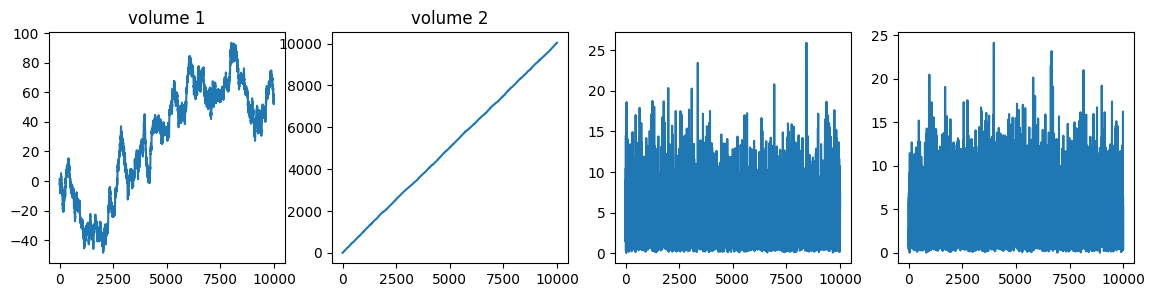

In [4]:
# plot of price
fig, axes = plt.subplots(figsize = (14,3), nrows=1, ncols=4)
axes[0].plot(ts1); axes[0].set_title("price 1")
axes[1].plot(ts2); axes[1].set_title("price 2")
axes[2].plot(vol1); axes[0].set_title("volume 1")
axes[3].plot(vol2); axes[1].set_title("volume 2")

## Bar Construction
### Motivation
The original data is sampled at different frequency at different time, and the number of data is huge (equals number of transactions...!). This makes us want to organize data in a more "regularlized" and possibly more "compact" way. Bar construction methods aim to find a nice way of deciding sampling strategy so that the data becomes more regular.

Below is an example of trasforming the original data into **tick bars**, which samples data at fixed number of ticks (transactions). The original data looks like:

In [5]:
#what original data looks like. timeは適当．
original = pd.DataFrame({"price": ts1, "volume":vol1, "time":np.cumsum(np.random.gamma(1,1,N_TIME))*0.1})
original.head(12).style.set_caption("ORIGINAL DATA TABLE")

,price,volume,time
0,1.279344,14.400997,0.020768
1,0.879406,2.550764,0.055399
2,-0.018667,6.063774,0.063610
3,1.277822,6.139153,0.330186
4,0.557056,1.391343,0.612366
5,0.510410,2.627223,0.736628
6,0.152818,6.995616,0.759869
7,-0.324238,1.661486,0.805436
8,-0.817418,10.482849,0.809784
9,-0.675618,4.526019,0.816871


Using tick bars with sampling period of 3, 3 contiguous rows in the original data are grouped (`bar_id`):

In [6]:
original['bar_id'] = np.repeat([i for i in range(int(np.ceil(N_TIME/3)))], 3)[:N_TIME]
original.head(12)

,price,volume,time,bar_id
0,1.279344,14.400997,0.020768,0
1,0.879406,2.550764,0.055399,0
2,-0.018667,6.063774,0.063610,0
3,1.277822,6.139153,0.330186,1
4,0.557056,1.391343,0.612366,1
5,0.510410,2.627223,0.736628,1
6,0.152818,6.995616,0.759869,2
7,-0.324238,1.661486,0.805436,2
8,-0.817418,10.482849,0.809784,2
9,-0.675618,4.526019,0.816871,3


the transformed data could look like:

In [7]:
# tick bars with sampling period of 3
a = original.groupby(by='bar_id').aggregate({"price":["first", "last", "max", "min"], "volume":["sum"]}).rename(columns={"max":"high","min":"low","first":"open","last":"close","sum":"total"})
b = original.groupby(by='bar_id').apply((lambda x: pd.Series(np.sum(x['volume'] * x['price'])/np.sum(x['volume']), index=["volume_weighted_price_average"])))
pd.concat([a,b],axis=1)

,"(price, open)","(price, close)","(price, high)","(price, low)","(volume, total)",volume_weighted_price_average
bar_id,,,,,,
0,1.279344,-0.018667,1.279344,-0.018667,23.015535,0.893040
1,1.277822,0.510410,1.277822,0.510410,10.157718,0.980610
2,0.152818,-0.817418,0.152818,-0.817418,19.139951,-0.419987
3,-0.675618,-3.065613,-0.675618,-3.065613,9.894725,-1.011702
4,-2.471721,-2.793048,-1.910829,-2.793048,12.341878,-2.379199
...,...,...,...,...,...,...
3329,53.589227,54.515690,54.515690,53.422512,19.257039,53.880791
3330,54.691881,55.431820,55.431820,53.807537,21.944305,54.786360
3331,54.362429,55.505848,55.505848,54.221226,8.378861,55.110669


## Tick Imbalance Bar
### Definition (in practice)
For the derivation of tick imbalance bar, we don't use the volume $v_i$.

Let $T_0$ be the first number of ticks to sample (as in the previous tick bar), to make the bar(row) \#1. The number of ticks to sample to make the $i$-th bar(row) $T_i$ is decided by the following rule: 

Suppose that up until the $i-1$ th row, $S_{i-1}$ rows are already used. Then, the index of original data that is used for row $i$ will be $S_{i-1}+1, S_{i-1}+2, \ldots, S_{i-1}+T_i$.

We first define the indicator of "imbalance" $\theta_t$ as:
\begin{align}
    \theta_{S_{i-1}} &= 0\\
    \theta_t &= \theta_{t-1} + b_t & (t > S_{i-1})
\end{align}
where
\begin{align}
    b_t = \begin{cases}
        &1 & \text{if  } ~~p_{t} > p_{t-1}\\
        &-1 & \text{if  } ~~p_{t} < p_{t-1} \\
        & b_{t-1} & \text{if  } ~~p_{t} = p_{t-1}
    \end{cases}
\end{align}

$\theta_t$ having large value indicates that there has been a large imbalance towards either upward or downward trend.

Then we choose $T_i$ to be the amount of ticks required to exceed a specified imbalance threshold:

\begin{align}
    T_i = \min \{t  : |\theta_t| \geq |2 \times \mathrm{EMA}(\{b_t\}_{t=1}^{S_{i-1}}) - 1| \times \mathrm{EMA}(\{T_{j}\}_{j=0}^{i-1}) \}
\end{align}
where $\mathrm{EMA}$ represents the exponential moving average.

#### Intuition

- $|2 \times \mathrm{EMA}(\{b_t\}_{t=1}^{S_{i-1}}) - 1|$ estimates $|2\times \mathrm{Pr}(b_t=1) - 1| = |\mathrm{Pr}(b_t=1) - \mathrm{Pr}(b_t=0)|$, so roughly this is the "expected imbalance per transaction".
- $\mathrm{EMA}(\{T_{j}\}_{j=0}^{i-1})$ is the (exponential) moving average of number of transactions in the previous bars.
- So their product roughly expresses the expected amount of imbalance in one row in the table.

### Simulation (Data 1)
As you can see from the definition of tick imbalance bar, in the case of $Pr[b_t=1]=0.5$, the threshold approaches $0$ and $T$ will be 1 over time (meaning that every transaction (tick) is adopted as one bar...)

In [8]:
# number of bars will be very large
tick_time, T_list, p1_list = tick_imbalance_bar(ts1)
print("number of bars:", len(tick_time), ", number of ticks:", N_TIME)
print("tail of p1_list", p1_list[-10:])

number of bars: 44 , number of ticks: 10000
tail of p1_list [0.6501302919342883, 0.7159386772110189, 0.689503910606272, 0.6657368497217783, 0.691477016297682, 0.6324282872825528, 0.38967465535287116, 0.6027299323082261, 0.662164601020281, 0.5769089269517532]


Text(0, 0.5, 'T')

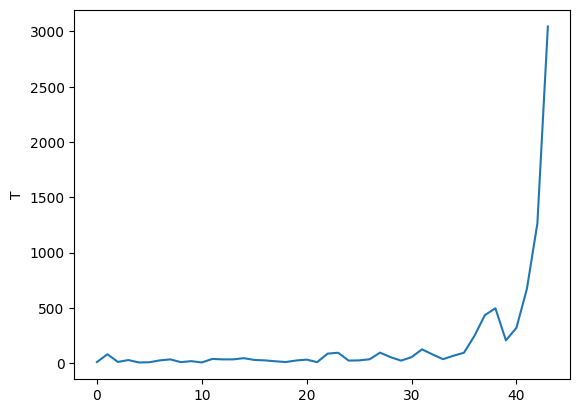

In [9]:
# plot of T_list: many T's are 1.
plt.plot(T_list)
plt.ylabel("T")

### Simulation (Data 2)
With trend term included in the original data, $Pr[b_t=1]$ is no longer $0.5$, so $T$ does not approach 1.

In this simulation, it seems like $T$ grows as time passes (even though the system never changed... that's the point?)

number of bars: 371 , number of ticks: 10000
tail of p1_list [0.8726439736467356, 0.7900916463709217, 0.8256434225648674, 0.8269950468030056, 0.7833451711605935, 0.934604178225505, 0.8799710625275544, 0.8715108258868008, 0.8528829269390978, 0.9065778016703897]


Text(0, 0.5, 'T')

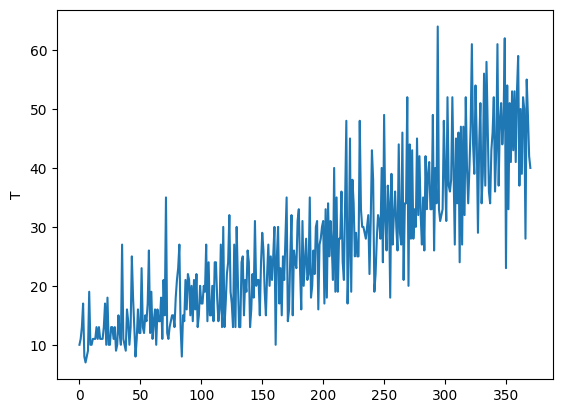

In [10]:
tick_time, T_list, p1_list = tick_imbalance_bar(ts2)
print("number of bars:", len(tick_time), ", number of ticks:", N_TIME)
print("tail of p1_list", p1_list[-10:])
plt.plot(T_list)
plt.ylabel("T")